# Separación de componentes con redes neuronals 
En este lab la idea es que separéis una señal en las distintas componentes que la consituyen. El caso que estudiaremos es el cielo en el rango de las microondas. La señal que nos llega es una mezcla de fondo cósmico de microondas (CMB), radiación debida al polvo térmico interestelar, y la radiación sincrotrón debida a partículas atravesando el campo magnético de nuestra Galaxia. Cuanto mejor las caractericemos, mejor las podremos estudiar, tanto para análisis cosmológicos (CMB) o para el estudio de nuestra Galaxia (sincrotrón y polvo). Así la señal que recibimos es a cada frecuencia $\nu$ es: 
\begin{equation}
S_{\nu}=S_{cmb}+S_{synch}+S_{dust}+noise
\end{equation}

Conocemos el modelo de como se comportan frecuencialmente estas componentes por separado y se puede caracterizar por 4 parámteros: Amplitud del Cmb ($A_{cmb}$), Amplitud del syncrotron e índice espectral del sincrotrón ($A_{s}$) y ($\beta_s$) y el polvo térmico con su amplitud a 353GHz $A_{d}$. 

Os vamos a dar tres data sets. Cada uno de ellos tendrá la señal (en K) con todas las componentes mezcladas más una contribución de ruido (debida a la sensibilidad del detector, cantidad de tiempo observado, etc.) y los 4 parámetros de las componentes: $A_{cmb}$, $A_{d}$ y $A_s$ y $\beta_s$ (detalles en la presentación):
* PLANCK:  9 frecuencias del satélite PLANCK de la ESA (30, 44, 70, 100, 143, 217, 353, 545, 857 GHZ).
* PLANCK + HASLAM : Añadimos un canal a muy baja frecuencia (0.408 GHz).

Los data sets los encontraréis en: SET+'_Signal_dataset.txt' y SET+'_Signal_labels.txt'

Trabajaremos con `healpy`, la parte de cargar mapas y visualizarlos está en este notebook. Podéis instalarlo con `pip install healpy`


# Ejercicio 1
   Buscaremos el mejor modelo para cada uno de los datasets y lo validaremos con uns simulación de mapas realistas
   *   **1.1.** Encuentra con una red neuronal un bueno modelo que relacione los inputs con los parámetros de las componentes para cada uno de los data sets.   
   *   **1.2.** Evalúa con una simulación independiente como de buenos son tus resultados. 
   *   **1.3.** Comenta qué parametros mejoran cuando añadimos una frecuencia más (más baja) y porqué. 

**(7 puntos)**

In [2]:
!pip install healpy

     |████████████████████████████████| 11.8MB 332kB/s 


In [0]:
# Packages needed
import numpy as np
import scipy.constants as cst
import matplotlib.pyplot as plt
import healpy as hp
cmap='coolwarm'
import keras

In [0]:
from keras import layers
from keras import models
from keras import optimizers
from keras import callbacks

In [0]:
# Data sets characteristics
def DataSet(FLAG):
    if FLAG=='PLANCK':
        freq=[30.,44.,70.,100.,143.,217.,353.,545.,857.]
        sigma=[2.8, 3.0, 4.0, 1.29, 0.55, 0.78, 2.56, 13.6, 100]
    if FLAG=='PLANCK+HASLAM':
        freq=[0.408,30.,44.,70.,100.,143.,217.,353.,545.,857.]
        sigma=[1E6,2.8, 3.0, 4.0, 1.29, 0.55, 0.78, 2.56, 13., 500]
    if FLAG=='PLANCK+HASLAM+QUIJOTE':
        freq=[0.408,11.,13.,17.,19.,30.,44.,70.,100.,143.,217.,353.,545.,857.]
        sigma=[1E6,10,10,10,10, 2.8, 3.0, 4.0, 1.29, 0.55, 0.78, 2.56, 13., 500]
    return freq,sigma

In [15]:
from google.colab import drive

drive.mount('/content/drive')

!ls "/content/drive/My Drive/DL-fisica"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
'1 CMB'


In [0]:
# Read data set
path = "/content/drive/My Drive/DL-fisica/1 CMB/"
SET='PLANCK'  

freq,sigma=DataSet(SET) # cargamos num de frecuencias , std del ruido, y valor maximo del synchrotron
nu_ref=freq[0]  # frecuencia donde evaluamos el synchrotron

Signal=np.loadtxt(path+SET+'_Signal_dataset.txt')   # 10000 x len(freq)
Labels=np.loadtxt(path+SET+'_Signal_labels.txt')    # 10000 x 4 params (A_cmb,A_s,beta_s,A_d)

In [60]:
# 1.1 Start obtaining your models with a NN
model_PLANCK = models.Sequential()
model_PLANCK.add(layers.Dense(2**6,activation="sigmoid",input_shape = (Signal.shape[1],)))
model_PLANCK.add(layers.Dropout(0.5))
model_PLANCK.add(layers.Dense(2**5,activation="sigmoid"))
model_PLANCK.add(layers.Dropout(0.5))
model_PLANCK.add(layers.Dense(2**4,activation="sigmoid"))
model_PLANCK.add(layers.Dropout(0.5))
model_PLANCK.add(layers.Dense(Labels.shape[1]))

model_PLANCK.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 64)                640       
_________________________________________________________________
dropout_22 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_23 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_24 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 4)               

In [61]:
callback_es = callbacks.EarlyStopping(patience = 10)

model_PLANCK.compile(optimizer = optimizers.Adam(lr = 0.5),loss="mse")
history_PLANCK = model_PLANCK.fit(Signal,Labels,batch_size = 2**6,epochs = 1000,validation_split = 0.2,callbacks=[callback_es])

Train on 80000 samples, validate on 20000 samples
Epoch 1/1000
80000/80000 [==============================] - 2s 27us/step - loss: 20596898.4224 - val_loss: 12536994.4208
Epoch 2/1000
80000/80000 [==============================] - 2s 25us/step - loss: 11016536.2320 - val_loss: 8871779.6480
Epoch 3/1000
80000/80000 [==============================] - 2s 25us/step - loss: 10079030.7572 - val_loss: 8590727.0784
Epoch 4/1000
80000/80000 [==============================] - 2s 25us/step - loss: 10036783.5540 - val_loss: 8589634.0568
Epoch 5/1000
80000/80000 [==============================] - 2s 25us/step - loss: 9902862.3956 - val_loss: 8523759.4832
Epoch 6/1000
80000/80000 [==============================] - 2s 25us/step - loss: 9616387.5016 - val_loss: 8518044.7872
Epoch 7/1000
80000/80000 [==============================] - 2s 25us/step - loss: 9525535.9340 - val_loss: 8518590.0744
Epoch 8/1000
80000/80000 [==============================] - 2s 25us/step - loss: 9391885.7468 - val_loss: 850531

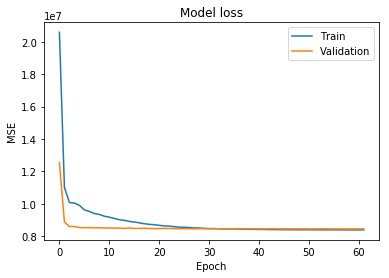

In [63]:
plt.plot(history_PLANCK.history['loss'])
plt.plot(history_PLANCK.history['val_loss'])
plt.title('Model loss')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [0]:
model_PLANCK.save(path+'PLANCK_model.h5')

In [0]:
# Read data set
path = "/content/drive/My Drive/DL-fisica/1 CMB/"
SET='PLANCK+HASLAM'  

freq,sigma=DataSet(SET) # cargamos num de frecuencias , std del ruido, y valor maximo del synchrotron
nu_ref=freq[0]  # frecuencia donde evaluamos el synchrotron

Signal=np.loadtxt(path+SET+'_Signal_dataset.txt')   # 10000 x len(freq)
Labels=np.loadtxt(path+SET+'_Signal_labels.txt')    # 10000 x 4 params (A_cmb,A_s,beta_s,A_d)

In [93]:
# 1.1 Start obtaining your models with a NN
model_PLANCK_HASLAM = models.Sequential()
model_PLANCK_HASLAM.add(layers.Dense(2**8,activation="sigmoid",input_shape = (Signal.shape[1],)))
model_PLANCK_HASLAM.add(layers.Dropout(0.25))
model_PLANCK_HASLAM.add(layers.Dense(2**7,activation="sigmoid"))
model_PLANCK_HASLAM.add(layers.Dropout(0.25))
model_PLANCK_HASLAM.add(layers.Dense(2**6,activation="sigmoid"))
model_PLANCK_HASLAM.add(layers.Dropout(0.25))
model_PLANCK_HASLAM.add(layers.Dense(2**5,activation="sigmoid"))
model_PLANCK_HASLAM.add(layers.Dropout(0.25))
model_PLANCK_HASLAM.add(layers.Dense(Labels.shape[1]))

model_PLANCK_HASLAM.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_76 (Dense)             (None, 256)               2816      
_________________________________________________________________
dropout_57 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_77 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_58 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_78 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_59 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_79 (Dense)             (None, 32)              

In [94]:
callback_es = callbacks.EarlyStopping(patience = 10)

model_PLANCK_HASLAM.compile(optimizer = optimizers.Adam(lr = 1000),loss="mse")
history_PLANCK_HASLAM = model_PLANCK_HASLAM.fit(Signal,Labels,batch_size = 2**6,epochs = 1000,validation_split = 0.2,callbacks=[callback_es])

Train on 80000 samples, validate on 20000 samples
Epoch 1/1000
80000/80000 [==============================] - 4s 50us/step - loss: 80421532436410464.0000 - val_loss: 77620377013889840.0000
Epoch 2/1000
80000/80000 [==============================] - 4s 46us/step - loss: 75193924543828096.0000 - val_loss: 72540406856016928.0000
Epoch 3/1000
80000/80000 [==============================] - 4s 49us/step - loss: 70246042926867864.0000 - val_loss: 67739249805307464.0000
Epoch 4/1000
80000/80000 [==============================] - 4s 47us/step - loss: 65608870926411320.0000 - val_loss: 63201782127425016.0000
Epoch 5/1000
80000/80000 [==============================] - 4s 47us/step - loss: 61190692185604040.0000 - val_loss: 58910892899436592.0000
Epoch 6/1000
80000/80000 [==============================] - 4s 46us/step - loss: 57038057542557000.0000 - val_loss: 54861023519692136.0000
Epoch 7/1000
80000/80000 [==============================] - 4s 47us/step - loss: 53147232524924304.0000 - val_loss: 

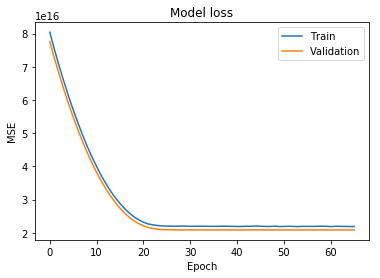

In [95]:
plt.plot(history_PLANCK_HASLAM.history['loss'])
plt.plot(history_PLANCK_HASLAM.history['val_loss'])
plt.title('Model loss')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [0]:
model_PLANCK_HASLAM.save(path+'PLANCK_HASLAM_model.h5')

# Ejercicio 1.2 
Con una simulación realista (Datos/Data+SET+.fits) donde sabemos cada una de las componentes, comprueba tus resultados y comenta qué efecto tiene añadir frecuencias bajas a la estimación de tus parámetros. Visualizad los mapas que obtendríais con la red y los de verdad (Datos/Params+SET+.fits) y evaluad las diferencias. 

**(3 puntos)**

In [0]:
# Cargamos con healpy los datos simulados 
nmaps=np.arange(0,len(freq))
Datos=hp.read_map('Datos/Data'+SET+'.fits',nmaps,verbose=False,dtype=np.float64)

# Los parametros que se han usado para generar estos datos son: 
True_params=hp.read_map('Datos/Params'+SET+'.fits',(0,1,2,3),verbose=False,dtype=np.float64)      

# Accedemos a los mapas frecuenciales y los parametros se acceden con Datos[i], True_params[i]

/usr/local/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


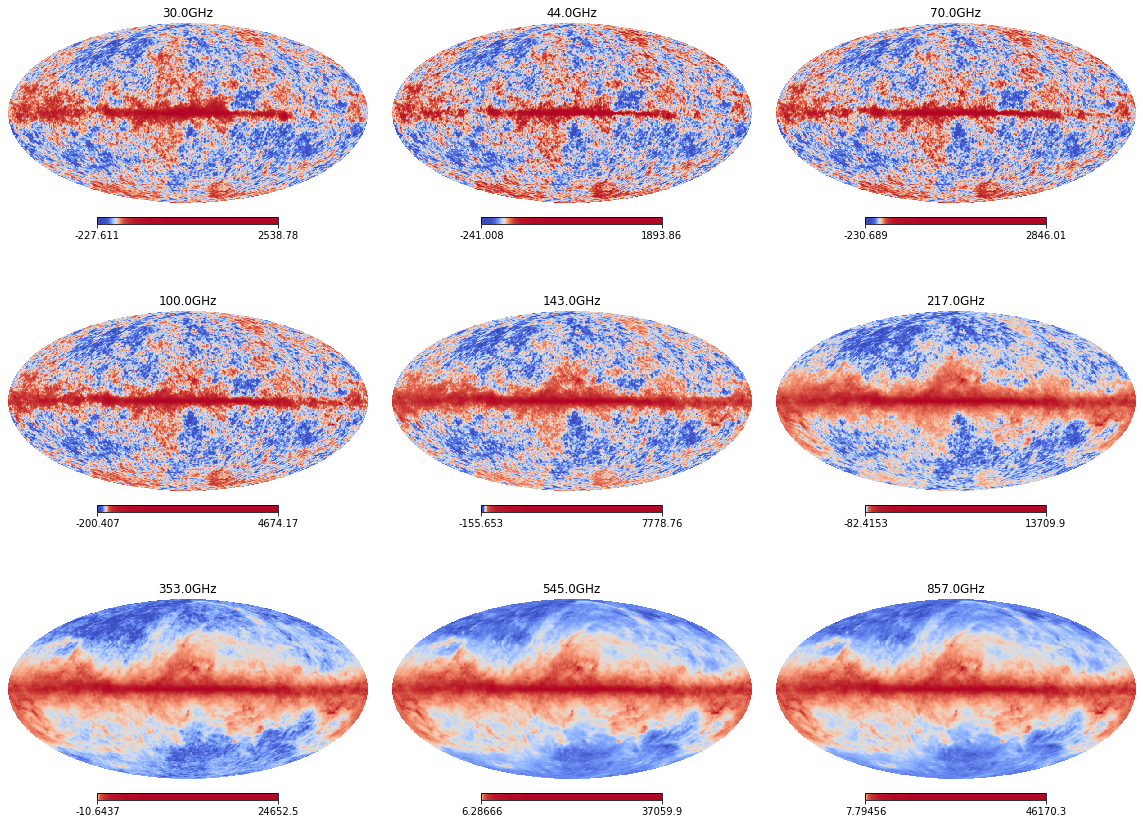

In [0]:
# Visualizamos los datos
pl.figure(0,figsize=(16,12))
if SET == 'PLANCK': n=3
if SET == 'PLANCK + HASLAM': n=4
if SET == 'PLANCK + HASLAM +QUIJOTE': n=5
for i in range(len(freq)):
    hp.mollview(Datos[i],sub=(n,3,i+1),norm='hist',title=str(freq[i])+'GHz',cmap=cmap)

In [0]:
# 1.2 Make predictions with your models and compare results
# and make a quantitative evaluation of your prediction (ex. correlation coefficient, mse,...)


In [0]:
# Visualize the prediciton and input maps:

# Example first parameter: 
# Use hp.mollview to visualize the maps and their differences:
# hp.mollview(Params_pred[:,0],cmap=cmap,sub=(1,3,1),title=r'$a_{cmb}$'+' NN',norm='hist')
# hp.mollview(True_params[0],cmap=cmap,sub=(1,3,2),title=r'$a_{cmb}$'+' input',norm='hist')
# hp.mollview(Params_pred[:,0]-True_params[0],cmap=cmap,sub=(1,3,3),title='Difference')
   

In [0]:
# 1.3  Comment what are the differences of both data sets


# Ejercicio 2. 
Para el caso PLANCK+HASLAM+QUIJOTE mandad vuestros resultados a la competición de Kaggle: https://www.kaggle.com/c/component-separation-with-nn. Podéis mandar tantos como queráis.

**(3 puntos)**